In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
from random import random
import math
import csv

MAX_AUDIO_DURATION = 1
MAX_SAMPLE_COUNT_PER_ARTIST = 100
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser('/Users/andrusasumets/projects/experiments/pacemaker/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
extensionpath = os.path.join(apppath, 'pacemaker WatchKit Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
metadatapath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/metadata/')
metadatacsvpath = os.path.join(apppath, 'processed/metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'
handpickedfilenames = ['220177', '406270', '14031', '124998', '148979', '421133', '190096', '517118', '446582', '390764', '390759', '505135', '421136', '148996', '346700', '164678', '325262', '335930', '422971', '190113', '164643', '221364', '446600', '394181', '494494', '164584', '316578', '394180', '406735', '375964']

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'downloads', 'rating', 'tags']
    rows = []

    for id in ids:
        with open(metadatapath + "/" + id) as file:
            id = int(id)
            line = file.readlines()[0]
            arguments = line.split('|')
            downloads = int(arguments[0].split('downloads:')[1])
            rating = int(arguments[1].split('rating:')[1])
            tags = arguments[2].split('tags:')[1]
            row = {
                'id': id,
                'downloads': downloads,
                'rating': rating,
                'tags': tags
            }
            rows.append(row)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 

metadata = read_csv(metadatacsvpath)
print(len(metadata))

68021
68021


In [3]:
DOWNLOADS_THRESHOLD = 100
RATING_THRESHOLD = 90

scored = []
for sample in metadata:
    id = sample['id']
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD:
        row = [id, downloads, rating, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[4]))
scored.reverse()

print(scored[0])

2697
['60007', 22076, 90, 'swipe,attack,bamboo,cut,domain,flup,h2,luft,public,public-domain,punch,stick,swash,swhish,air,swish,swoosh,swosh,weapon,whip,whoosh,wind,wisch,wish,woosh,zoom,zoom-h2,swing', 1986840]


In [4]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

print(1, len(filenames))
print(filenames[0])
for filename in filenames:
    id = filename.split('__')[0]
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
filenames = filtered
print(2, len(filenames))

fileformats {'flac': 2887, 'wav': 45750, 'mp3': 2820, 'aiff': 18979, 'ogg': 679, 'm4a': 142, 'crdownload': 15, 'DS_Store': 1}
all_filenames: 71273
1 71257
453328__kyles__machine-metal-vibrating-grinding-drilling-hole-maybe.flac
2 2696


In [5]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [6]:
def process(command):
    subprocess.check_output(command)

sample_artists = {}
sample_durations = {}
res = []

for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat

        if fileartist not in sample_artists:
            sample_artists[fileartist] = 0

        sample_artists[fileartist] = sample_artists[fileartist] + 1

        if sample_artists[fileartist] >= MAX_SAMPLE_COUNT_PER_ARTIST:
            continue

        soxi_out = create_or_read_file(['soxi', '-D', librarypath + filename], soxipath + fileid + '.soxi')
        if not soxi_out:
            continue

        sample_duration = float(soxi_out)
        if sample_duration > MAX_AUDIO_DURATION:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        sample_durations[fileid] = sample_duration
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))
print(sample_artists)

ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162363__qubodup__distant-explosion-of-propelled-grenade.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-23.22:measured_lra=0.0:measured_tp=-3.28:measured_thresh=-34.92:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/aazzdjyp.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162363__qubodup__distant-explosion-of-propelled-grenade.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-23.22:measured_lra=0.0:measured_tp=-3.28:measured_thresh=-34.92:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162363__qubodup__distant-explosion-of-propelled-grenade.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162363__qubodup__distant-explosion-of-propelled-grenade.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/391704__jpolito__jp-tinypadlock01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.15:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cffqpl_o.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/391704__jpolito__jp-tinypadlock01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.15:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/391704__jpolito__jp-tinypadlock01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/391704__jpolito__jp-tinypadlock01.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395338__ihitokage__swish-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395338__ihitokage__swish-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n5qsrckv.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/98905__kuru23__goakick01.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128257__rebeat__breaking-dish-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-16.47:measured_lra=0.0:measured_tp=0.43:measured_thresh=-28.66:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6s_rm1al.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128257__rebeat__breaking-dish-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-16.47:measured_lra=0.0:measured_tp=0.43:measured_thresh=-28.66:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128257__rebeat__breaking-dish-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128257__rebeat__breaking-dish-2.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545338__stwime__beep-boop.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545338__stwime__beep-boop.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459217__soneproject__kick80.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.03:measured_i=-19.73:measured_lra=0.0:measured_tp=0.02:measured_thresh=-31.42:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/c4mftogz.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459217__soneproject__kick80.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.03:measured_i=-19.73:measured_lra=0.0:measured_tp=0.02:measured_thresh=-31.42:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459217__soneproject__kick80.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459217__soneproject__kick80.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536759__egomassive__frog.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536759__egomassive__frog.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ek034c4f.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-m

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60012__qubodup__swing-25.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lskzn3l9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59998__qubodup__weapon-swing-air-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-16.39:measured_lra=0.0:measured_tp=-4.73:measured_thresh=-26.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pw82pgcq.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-16.39:measured_lra=0.0:measured_tp=-4.73:measured_thresh=-26.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67648__qubodup__movement-right-there-soldier-radio-talk.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/u2ab_06r.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536736__egomassive__chop.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536736__egomassive__chop.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/252815__soneproject__sfx7.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-18.11:measured_lra=0.0:measured_tp=-4.97:measured_thresh=-30.31:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k6e2moom.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/252815__soneproject__sfx7.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-18.11:measured_lra=0.0:measured_tp=-4.97:measured_thresh=-30.31:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252815__soneproject__sfx7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252815__soneproject__sfx7.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545373__stwime__up3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545373__stwime__up3.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154888__unfa__beep-bad.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/154888__unfa__beep-bad.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395331__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395331__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323189__alivvie__complain2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323189__alivvie__complain2.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536786__egomassive__screamm.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536786__egomassive__screamm.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/a1ehijzp.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/9633__heigh-hoo__mute-1.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/71274__qubodup__dull-decompression-punch-impact-explodes-96khz.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-15.45:measured_lra=0.0:measured_tp=0.36:measured_thresh=-28.45:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0q1suq3s.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/71274__qubodup__dull-decompression-punch-impact-explodes-96khz.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-15.45:measured_lra=0.0:measured_tp=0.36:measured_thresh=-28.45:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/71274__qubodup__dull-decompression-punch-impact-explodes-96khz.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/71274__qubodup__dull-decompression-punch-impact-explodes-96khz.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128269__rebeat__scrap-and-fall.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.95:measured_lra=0.0:measured_tp=0.26:measured_thresh=-29.95:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/duyibqpx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128269__rebeat__scrap-and-fall.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.95:measured_lra=0.0:measured_tp=0.26:measured_thresh=-29.95:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128269__rebeat__scrap-and-fall.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128269__rebeat__scrap-and-fall.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67650__qubodup__voice-male-radio-auto-range-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-12.28:measured_lra=0.0:measured_tp=-3.41:measured_thresh=-22.28:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k3vxwktg.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67650__qubodup__voice-male-radio-auto-range-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-12.28:measured_lra=0.0:measured_tp=-3.41:measured_thresh=-22.28:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67650__qubodup__voice-male-radio-auto-range-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67650__qubodup__voice-male-radio-auto-range-1.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395332__ihitokage__grab-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395332__ihitokage__grab-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=14.37:measured_i=-23.67:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-33.67:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wl1ljeai.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=14.37:measured_i=-23.67:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-33.67:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128261__rebeat__dish-thump.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-19.46:measured_lra=0.0:measured_tp=-2.02:measured_thresh=-31.19:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/srnvsqz5.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-19.46:measured_lra=0.0:measured_tp=-2.02:measured_thresh=-31.19:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534110__pbimal__rubber-ball-01.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395367__ihitokage__swish-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395367__ihitokage__swish-2.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mtjedzod.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/340810__cabled-mess__alien-interface-communication-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/klz269ft.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60003__qubodup__loud-swosh-16.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537897__belanhud__balloon-pop-one.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/537897__belanhud__balloon-pop-one.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395363__ihitokage__hit-5.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395363__ihitokage__hit-5.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-21.69:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-31.69:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/h_fndkct.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-21.69:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-31.69:linear=true:prin

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536765__egomassive__squish.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536765__egomassive__squish.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463214__se2001__evan-s-single-bounce.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/463214__se2001__evan-s-single-bounce.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/193424__unfa__enemy-die-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.49:measured_lra=0.0:measured_tp=-9.63:measured_thresh=-27.49:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ikskjpz3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/193424__unfa__enemy-die-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.49:measured_lra=0.0:measured_tp=-9.63:measured_thresh=-27.49:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/193424__unfa__enemy-die-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/193424__unfa__enemy-die-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536773__egomassive__siren.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536773__egomassive__siren.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395335__ihitokage__woosh-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395335__ihitokage__woosh-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458669__jorgerosa__missile-launch.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458669__jorgerosa__missile-launch.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395340__ihitokage__woosh-5.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395340__ihitokage__woosh-5.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b4m71fbt.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59997__qubodup__swosh-10.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60007__qubodup__swipe-whoosh.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.55:measured_lra=0.0:measured_tp=0.0:measured_thresh=-27.55:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/boaxml8f.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60007__qubodup__swipe-whoosh.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.55:measured_lra=0.0:measured_tp=0.0:measured_thresh=-27.55:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60007__qubodup__swipe-whoosh.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60007__qubodup__swipe-whoosh.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154887__unfa__beep-good.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/154887__unfa__beep-good.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-9.52:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-19.52:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bhs2c4a6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-9.52:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-19.52:linear=true:print_format=json[norm0]', '-map_metadata', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/340809__cabled-mess__retro-sci-fi-horror-06.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/277643__coral-island-studios__button-14.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/277643__coral-island-studios__button-14.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323194__alivvie__hai-yes-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323194__alivvie__hai-yes-2.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521951__kastenfrosch__weird-grunt.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/521951__kastenfrosch__weird-grunt.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395327__ihitokage__block-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395327__ihitokage__block-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/391702__jpolito__jp-tinypadlock03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=24.69:measured_i=-22.54:measured_lra=0.0:measured_tp=-1.41:measured_thresh=-32.54:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xsra1bvx.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/391702__jpolito__jp-tinypadlock03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=24.69:measured_i=-22.54:measured_lra=0.0:measured_tp=-1.41:measured_thresh=-32.54:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/391702__jpolito__jp-tinypadlock03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/391702__jpolito__jp-tinypadlock03.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534111__pbimal__rubber-ball-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-22.85:measured_lra=0.0:measured_tp=-2.36:measured_thresh=-35.69:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jtvlkeh9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534111__pbimal__rubber-ball-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-22.85:measured_lra=0.0:measured_tp=-2.36:measured_thresh=-35.69:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534111__pbimal__rubber-ball-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534111__pbimal__rubber-ball-00.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/277645__coral-island-studios__button-10.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/277645__coral-island-studios__button-10.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395336__ihitokage__woosh-10.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395336__ihitokage__woosh-10.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323498__spennnyyy__movie-cut-sound.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323498__spennnyyy__movie-cut-sound.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162403__qubodup__m16-single-shot-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-5.99:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-17.74:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0piyvevd.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162403__qubodup__m16-single-shot-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-5.99:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-17.74:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadat

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162403__qubodup__m16-single-shot-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162403__qubodup__m16-single-shot-5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.79:measured_lra=0.0:measured_tp=0.51:measured_thresh=-29.71:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8ytef4vi.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.79:measured_lra=0.0:measured_tp=0.51:measured_thresh=-29.71:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128268__rebeat__throwing-cup.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/415556__hullum__glitch-robot-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-9.38:measured_lra=0.0:measured_tp=1.21:measured_thresh=-19.38:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rya_oy8m.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/415556__hullum__glitch-robot-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-9.38:measured_lra=0.0:measured_tp=1.21:measured_thresh=-19.38:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/415556__hullum__glitch-robot-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/415556__hullum__glitch-robot-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49051__suspiciononline__moca-style-snare-06.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49051__suspiciononline__moca-style-snare-06.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59994__qubodup__swosh-07.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fzxj6868.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59994__qubodup__swosh-07.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59994__qubodup__swosh-07.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59994__qubodup__swosh-07.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59992__qubodup__swosh-sword-swing.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-18.15:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-28.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yw_zvg2w.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59992__qubodup__swosh-sword-swing.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-18.15:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-28.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59992__qubodup__swosh-sword-swing.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59992__qubodup__swosh-sword-swing.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/172174__unfa__beidl.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-12.81:measured_lra=0.0:measured_tp=-0.09:measured_thresh=-22.81:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5klchjxi.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/172174__unfa__beidl.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-12.81:measured_lra=0.0:measured_tp=-0.09:measured_thresh=-22.81:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/172174__unfa__beidl.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/172174__unfa__beidl.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67651__qubodup__voice-male-radio-positive-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-15.05:measured_lra=0.0:measured_tp=-4.78:measured_thresh=-25.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jgc598iy.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67651__qubodup__voice-male-radio-positive-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-15.05:measured_lra=0.0:measured_tp=-4.78:measured_thresh=-25.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67651__qubodup__voice-male-radio-positive-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67651__qubodup__voice-male-radio-positive-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/155892__unfa__yeah-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-13.72:measured_lra=0.0:measured_tp=0.0:measured_thresh=-24.94:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/h9kxkpkp.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/155892__unfa__yeah-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-13.72:measured_lra=0.0:measured_tp=0.0:measured_thresh=-24.94:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155892__unfa__yeah-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/155892__unfa__yeah-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395358__ihitokage__hit-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395358__ihitokage__hit-4.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128258__rebeat__breaking-dish-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.29:measured_lra=0.0:measured_tp=1.12:measured_thresh=-28.04:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kitp4s3x.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128258__rebeat__breaking-dish-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.29:measured_lra=0.0:measured_tp=1.12:measured_thresh=-28.04:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128258__rebeat__breaking-dish-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128258__rebeat__breaking-dish-1.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162402__qubodup__m203-grenade-launcher-1.flac']' returned non-zero exit status 1.
['421129.m4a', '13856.m4a', '346706.m4a', '1434.m4a', '443808.m4a', '467784.m4a', '136794.m4a', '203049.m4a', '404743.m4a', '13822.m4a', '50970.m4a', '220174.m4a', '405645.m4a', '211614.m4a', '89649.m4a', '319525.m4a', '33912.m4a', '104245.m4a', '99734.m4a', '409360.m4a', '345440.m4a', '148975.m4a', '524952.m4a', '473578.m4a', '422967.m4a', '329355.m4a', '494493.m4a', '522165.m4a', '127542.m4a', '99737.m4a', '220181.m4a', '25667.m4a', '148996.m4a

ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-12.86:measured_lra=0.0:measured_tp=1.07:measured_thresh=-22.86:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9jjevfop.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-12.86:measured_lra=0.0:measured_tp=1.07:measured_thresh=-22.86:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

In [7]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    rightfilenames = sorted(rightfilenames, key=lambda x: random())
    
    if leftid not in handpickedfilenames:
        continue
        
    print(leftid)
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            sample_duration = sample_durations[leftid]
            out_distances[leftid].append([correlation, sample_duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

ibswscale      6.  7.100 /  6.  7.100
libswresample   4.  7.100 /  4.  7.100
libpostproc    56.  6.100 / 56.  6.100
Input #0, flac, from '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac':
Duration: 00:00:00.53, start: 0.000000, bitrate: 899 kb/s
Stream #0:0: Audio: flac, 44100 Hz, stereo, s32 (24 bit)
Stream mapping:
Stream #0:0 (flac) -> loudnorm:default
loudnorm:default -> Stream #0:0 (pcm_s32le)
[flac @ 0x7f9f78006c00] Invalid audio stream. Exactly one FLAC audio stream is required.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 --
[Parsed_loudnorm_0 @ 0x7f9f78204a00]
{
"input_i" : "-inf",
"input_tp" : "-inf",
"input_lra" : "0.00",
"input_thresh" : "-70.00",
"output_i" : "-inf",
"output_tp" : "-inf",
"output_lra" : "0.00",
"output_thresh" : "-70.00",
"normalization_type" : "dynamic",
"target_offset" : "inf"
}
Conversion failed!
Traceback (most recent call last):


148996
0 / 361000


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


316578
335930


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


406735
346700


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)


190113
446582
325262
422971
164678
390764
446600
190096
164584
494494
421133
148979
394181
124998
390759
221364
6100 / 361000
517118
406270
14031
220177
375964
421136
394180
164643
505135
9150


In [8]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [9]:
saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue
        
    saved.append(leftid)
    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    command = ['cp', source, target]
    process(command)

print(len(saved))

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

30


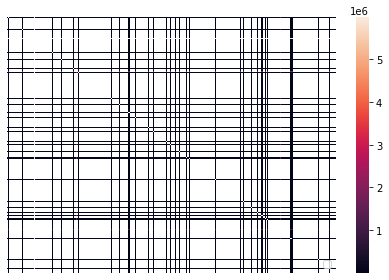

In [10]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(extensionpath + "heatmap.png", dpi=1000, facecolor="white")

In [11]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.346657682134219


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0.45330843983853353


0.6391893610891475


0.7716808700592486


0.9661021861086355


5981927.357438015


5981989.32438357


5982236.51


5982529.127551021


5984211.450000001
